# pipecaster tutorial

additional libraries required to execute this notebook:  
* matplotlib  
* scipy  

In [1]:
# Make synthetic data
import pipecaster as pc

n_input_matrices = 10
random_inputs = 7

Xs, y, X_types = pc.make_multi_input_classification(
                        n_informative_Xs=0,
                        n_weak_Xs=n_input_matrices-random_inputs,
                        n_random_Xs=random_inputs,
                        weak_noise_sd=.5,
                        seed=None,
                        n_classes=2, 
                        n_samples=500, 
                        n_features=100, 
                        n_informative=5, 
                        n_redundant=0, 
                        n_repeated=0, 
                        class_sep=2) 

## Feature Score-based Channel Selection and Channel Meta-prediction

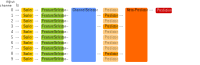

In [170]:
from IPython.display import SVG, display
display(SVG('images/tutorial_1.1.svg'))

*This pipeline is implemented with the code in the next cell.*  

This example illustrates many of pipecaster's features as well as the performance advantage of using a multichannel ML architecture.  The pipeline takes 10 input matrices with varying degrees of predictive value.  In practice, these matrices might come from ten different data sources or a single data source with ten different feature extraction variants.

**scaling and feature selection**  
The scaler and feauture selector algorithms used in the example below, StandardScaler() and SelectPercentile(), are scikit-learn estimator/transformers that are broadcast across all inputs.  

**channel selection**  
The channel selector used in this example, **SelectKBestScores**, computes a univariate feature score for each feature of a matrix then aggregates the score into a single value using an aggregator function (in this example np.mean).  The top k scoring channels are then selected for output (k=3 in this example).

Related classes: **SelectPercentBestScores**, **SelectHighPassScores**, **SelectVarianceHighPassScores**

**base prediction**  
The features output by SelectKBestScores are then used to train one GradientBoostingClassifier for each active channel (3 in this case, since the other 7 channels were not selected).  Pipecaster automatically provides internal cross validation training by default to reduce overfitting of meta-predictors (default training behavior can be altered in the MultichannelPipeline interface).

**meta-prediction**  
The multichannel meta-predictor, **MultichannelPredictor**, concatenates the base predictions into a single meta-feature vector and trains a meta-predictor (in this case scikit-learn's support vector machine classifier SVC).

In [164]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC 

early_stopping_GBC = GradientBoostingClassifier(n_estimators=1000, 
                                     validation_fraction=0.1, 
                                     n_iter_no_change=3)
mclf1 = pc.MultichannelPipeline(n_channels=n_input_matrices)
mclf1.add_layer(StandardScaler())
mclf1.add_layer(SelectPercentile(percentile=100))
mclf1.add_layer(pc.SelectKBestScores(feature_scorer=f_classif, aggregator=np.mean, k=10))
mclf1.add_layer(early_stopping_GBC)
mclf1.add_layer(pc.MultichannelPredictor(SVC()))
mclf1

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4
channel,,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestScores,→,GradientBoostingClassifier,→,MultichannelPredictor,→
1,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
2,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
3,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
4,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
5,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
6,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
7,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
8,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→


**Notes on dataframe visualization**: 
* Before model fitting, all channels show outputs even though some will not ultimately be selected.  This is because pipecaster can't tell which channels will be selected prior to model fitting.  
* Inverted triangles indicate that the channels are spanned by the multichannel pipe shown directly above.  
* The channel and layer indices seen on the left and top can be used to reference specific object instances in the pipeline (see MultichannelPipeline interface annotations).  

In [165]:
df = mclf1.fit(Xs, y).get_dataframe()
df['input_type'] = X_types
df

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4,input_type
channel,,,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestScores,→,{GradientBoostingClassifier}cvtr,→,{MultichannelPredictor}tr,→,random
1,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
2,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,random
3,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,random
4,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,random
5,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,random
6,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
7,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,random
8,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative


**Notes on dataframe visualization**: 
* The type of input matrix appears in the input_type column on the right.
* The informative inputs, shown in input_type column, should exactly match the output arrows in the out_2 column if channel selection was perfect.
* GradientBoostingClassifier appears in brackets followed by 'cvtr' to indicate that the classifier has been wrapped with a class that provides internal cross validation training to prevent overfitting of downstream metaclassifiers.
* MultichannelPredictor appears in brackets followed by 'tr' to indicate that it has been wrapped to provide a transform() method that predictors ordinarily lacks. 

### Performance analysis

In [173]:
random_inputs = 7
weak_inputs = 0
strong_inputs = 3
n_input_matrices = random_inputs + weak_inputs + strong_inputs

Xs, y, X_types = pc.make_multi_input_classification(
                        n_informative_Xs=strong_inputs,
                        n_weak_Xs=weak_inputs,
                        n_random_Xs=random_inputs,
                        weak_noise_sd=None,
                        seed=None,
                        n_classes=2, 
                        n_samples=500, 
                        n_features=100, 
                        n_informative=20, 
                        n_redundant=0, 
                        n_repeated=0, 
                        class_sep=2) 

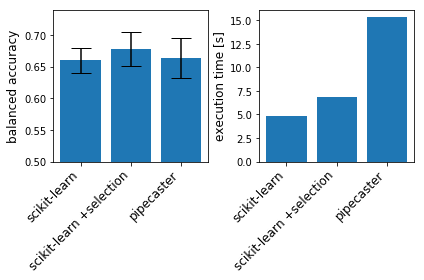

In [174]:
%matplotlib inline
import time
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from scipy.stats import sem

n_cpus = pc.count_cpus()

t = time.time()
pc_accuracies = pc.cross_val_score(mclf1, Xs, y, scorer=balanced_accuracy_score, cv=10, n_processes=n_cpus)
pc_time = time.time() - t

X = np.concatenate(Xs, axis=1)
clf = Pipeline([('scaler', StandardScaler()), 
                ('selector', SelectPercentile(score_func=f_classif, percentile=100)),
                ('GradientBoostingClassifier', early_stopping_GBC)])
t = time.time()
sk_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=10, n_jobs=n_cpus)
sk_time = time.time() - t

clf = Pipeline([('GradientBoostingClassifier', early_stopping_GBC)])
t = time.time()
sk_ns_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=10, n_jobs=n_cpus)
sk_ns_time = time.time() - t

fig, axes = plt.subplots(1, 2)
xlabels = ['scikit-learn', 'scikit-learn +selection', 'pipecaster']
axes[0].bar(xlabels, [np.mean(sk_ns_accuracies), np.mean(sk_accuracies), np.mean(pc_accuracies)], 
        yerr=[sem(sk_ns_accuracies), sem(sk_accuracies), sem(pc_accuracies)], capsize=10)
axes[0].set_ylim(.5)
axes[0].set_ylabel('balanced accuracy', fontsize=12)
axes[0].set_xticklabels(xlabels, rotation=45, ha='right', fontsize=12)
axes[1].bar(xlabels, [np.mean(sk_ns_time), np.mean(sk_time), np.mean(pc_time)])
axes[1].set_ylabel('execution time [s]', fontsize=12)
axes[1].set_xticklabels(xlabels, rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.savefig('performance_comparison.svg')

**Results**  
The pipecaster pipeline performs better on this task than pipeline architectures that take concatenated features (scikit-learn, and scikit-learn + selection).  The synthetic dataset used in this example consists of 3 informative input matrices and 7 random matrices.  This performance advantage can also be seen with noisy real-world datasets.

Text(0, 0.5, 'balanced accuracy')

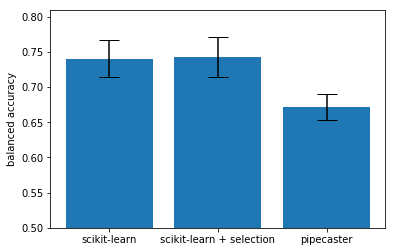

In [197]:
n_input_matrices = 10
random_inputs = 0

Xs_2, y_2, X_types_2 = pc.make_multi_input_classification(
                        n_informative_Xs=n_input_matrices-random_inputs, 
                        n_weak_Xs=0,
                        n_random_Xs=random_inputs,
                        weak_noise_sd=None,
                        seed=None,
                        n_classes=2, 
                        n_samples=500, 
                        n_features=100, 
                        n_informative=30, 
                        n_redundant=0, 
                        n_repeated=0, 
                        class_sep=2)  

pc_accuracies = pc.cross_val_score(mclf1, Xs_2, y_2, scorer=balanced_accuracy_score, cv=10)

X_2 = np.concatenate(Xs_2, axis=1)
clf = Pipeline([('scaler', StandardScaler()), 
                ('selector', SelectPercentile(score_func=f_classif, percentile=25)),
                ('GradientBoostingClassifier', early_stopping_GBC)])
sk_accuracies = cross_val_score(clf, X_2, y_2, scoring='balanced_accuracy', cv=10)

clf = Pipeline([('GradientBoostingClassifier', early_stopping_GBC)])
sk_ns_accuracies = cross_val_score(clf, X_2, y_2, scoring='balanced_accuracy', cv=10)

plt.bar(['scikit-learn', 'scikit-learn + selection', 'pipecaster'], 
        [np.mean(sk_ns_accuracies), np.mean(sk_accuracies), np.mean(pc_accuracies)], 
        yerr= [sem(sk_ns_accuracies), sem(sk_accuracies), sem(pc_accuracies)], capsize=10)
plt.ylim(.5)
plt.ylabel('balanced accuracy')

**Results**  
Multichannel ML doesn't confer a performance advantage on this synthetic dataset when all the input matrices are equally informative.

## Selecting Channels with ML probes

This example demonstrates how to select input channels based on the the performance of a temporary ML probe.  Here the **SelectKBestProbes** class is used in conjunction with a low complexity GradientBoostingClassifier probe.  SelectKBestProbes computes a cross validation run on each channel (one model per channel) and uses prediction accuracy as a nonlinear estimate of channel information content.  The ML probes and their predictions are then discarded and the selected channels passed through to the next pipeline layer. The pipeline architecture is identical to the one illustrated in example 1.1, except SelectKBestProbes replaces SelectKBestScores.

Related classes: **SelectPercentBestProbes**, **SelectHighPassProbes**, **SelectVarianceHighPassProbes**

In [87]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import pipecaster as pc

early_stopping_GBC = GradientBoostingClassifier(n_estimators=1000, 
                                     validation_fraction=0.1, 
                                     n_iter_no_change=3)
mclf2 = pc.MultichannelPipeline(n_channels=n_input_matrices)
mclf2.add_layer(StandardScaler())
mclf2.add_layer(SelectPercentile(percentile=25))
probe = GradientBoostingClassifier(n_estimators=10)
mclf2.add_layer(pc.SelectKBestProbes(predictor_probe=probe, cv=3, scorer='auto', k=3))
mclf2.add_layer(early_stopping_GBC)
mclf2.add_layer(pc.MultichannelPredictor(SVC()))
mclf2

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4
channel,,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestProbes,→,GradientBoostingClassifier,→,MultichannelPredictor,→
1,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
2,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
3,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
4,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
5,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
6,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
7,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→
8,StandardScaler,→,SelectPercentile,→,▽,→,GradientBoostingClassifier,→,▽,→


In [88]:
df = mclf2.fit(Xs, y).get_dataframe()
df['input_type'] = X_types
df

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4,input_type
channel,,,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestProbes,→,{GradientBoostingClassifier}cvtr,→,{MultichannelPredictor}tr,→,informative
1,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
2,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
3,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
4,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
5,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
6,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
7,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
8,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative


**Notes on dataframe visualization**: 
* The type of input matrix appears in the input_type column on the right.
* The informative inputs, shown in input_type column, should exactly match the output arrows in the out_2 column if channel selection was perfect.

In [89]:
accuracies = pc.cross_val_score(mclf2, Xs, y, scorer=balanced_accuracy_score, cv=5)
print('balanced accuracy = {} +/- {}'.format(np.mean(accuracies), sem(accuracies)))

balanced accuracy = 0.6557326930772308 +/- 0.016295301136997186


## In-pipeline Model Screening and Channel Meta-Prediction

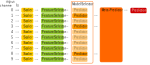

In [90]:
from IPython.display import SVG, display
display(SVG('images/tutorial_1.3.svg'))

*This pipeline is implemented with the code in the next cell.*  

This example illustrates use of the model selector class **SelectKBestModels**.  This class does an internal cross validation run on each channel (one model per channel) and uses the results to estimate model performance and generate outputs for meta-prediction.  The final base predictor models are trained on the entire training set (no internal cross validation).

Related classes: **SelectPercentBestModels**, **SelectHighPassModels**, **SelectVarianceHighPassModels**

In [91]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import pipecaster as pc

early_stopping_GBC = GradientBoostingClassifier(n_estimators=1000, 
                                     validation_fraction=0.1, 
                                     n_iter_no_change=3)
mclf3 = pc.MultichannelPipeline(n_channels=n_input_matrices)
mclf3.add_layer(StandardScaler())
mclf3.add_layer(SelectPercentile(percentile=25))
mclf3.add_layer(pc.SelectKBestModels(early_stopping_GBC, cv=5, scorer='auto', k=3))
mclf3.add_layer(pc.MultichannelPredictor(SVC()))
mclf3

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3
channel,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestModels,→,MultichannelPredictor,→
1,StandardScaler,→,SelectPercentile,→,▽,→,▽,→
2,StandardScaler,→,SelectPercentile,→,▽,→,▽,→
3,StandardScaler,→,SelectPercentile,→,▽,→,▽,→
4,StandardScaler,→,SelectPercentile,→,▽,→,▽,→
5,StandardScaler,→,SelectPercentile,→,▽,→,▽,→
6,StandardScaler,→,SelectPercentile,→,▽,→,▽,→
7,StandardScaler,→,SelectPercentile,→,▽,→,▽,→
8,StandardScaler,→,SelectPercentile,→,▽,→,▽,→


In [92]:
df = mclf3.fit(Xs, y).get_dataframe()
df['input_type'] = X_types
df

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,input_type
channel,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestModels,→,{MultichannelPredictor}tr,→,informative
1,StandardScaler,→,SelectPercentile,→,▽,,▽,,random
2,StandardScaler,→,SelectPercentile,→,▽,,▽,,random
3,StandardScaler,→,SelectPercentile,→,▽,,▽,,random
4,StandardScaler,→,SelectPercentile,→,▽,,▽,,random
5,StandardScaler,→,SelectPercentile,→,▽,→,▽,,informative
6,StandardScaler,→,SelectPercentile,→,▽,,▽,,random
7,StandardScaler,→,SelectPercentile,→,▽,,▽,,random
8,StandardScaler,→,SelectPercentile,→,▽,→,▽,,informative


**Notes on dataframe visualization**: 
* The type of input matrix appears in the input_type column on the right.
* The informative inputs, shown in input_type column, should exactly match the output arrows in the out_2 column if channel selection was perfect.

In [93]:
accuracies = pc.cross_val_score(mclf3, Xs, y, scorer=balanced_accuracy_score, cv=5)
print('balanced accuracy = {} +/- {}'.format(np.mean(accuracies), sem(accuracies)))

balanced accuracy = 0.61425050020008 +/- 0.01838659163496269


## Use Channel Mapping to Mix-and-Match Channels and Algorithms

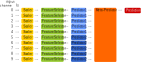

In [94]:
from IPython.display import SVG, display
display(SVG('images/tutorial_1.4.svg'))

*This pipeline is implemented with the code in the next cell.*  

The previous examples have broadcast a single algorithm across all channels, but it's easy to set each algorithm separately by providing a list with one algorithm for each channel (not shown), or by providing an alternating list of integers specifying the number of channels to map and algorithms to map to those channels (see next cell).

In [95]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import pipecaster as pc

mclf4 = pc.MultichannelPipeline(n_channels=n_input_matrices)
mclf4.add_layer(StandardScaler())
mclf4.add_layer(SelectPercentile(percentile=25))
mclf4.add_layer(5, GradientBoostingClassifier(), 5, KNeighborsClassifier())
mclf4.add_layer(pc.MultichannelPredictor(SVC()))
mclf4

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3
channel,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,GradientBoostingClassifier,→,MultichannelPredictor,→
1,StandardScaler,→,SelectPercentile,→,GradientBoostingClassifier,→,▽,→
2,StandardScaler,→,SelectPercentile,→,GradientBoostingClassifier,→,▽,→
3,StandardScaler,→,SelectPercentile,→,GradientBoostingClassifier,→,▽,→
4,StandardScaler,→,SelectPercentile,→,GradientBoostingClassifier,→,▽,→
5,StandardScaler,→,SelectPercentile,→,KNeighborsClassifier,→,▽,→
6,StandardScaler,→,SelectPercentile,→,KNeighborsClassifier,→,▽,→
7,StandardScaler,→,SelectPercentile,→,KNeighborsClassifier,→,▽,→
8,StandardScaler,→,SelectPercentile,→,KNeighborsClassifier,→,▽,→


In [96]:
mclf4.fit(Xs, y)

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3
channel,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,{GradientBoostingClassifier}cvtr,→,{MultichannelPredictor}tr,→
1,StandardScaler,→,SelectPercentile,→,{GradientBoostingClassifier}cvtr,→,▽,
2,StandardScaler,→,SelectPercentile,→,{GradientBoostingClassifier}cvtr,→,▽,
3,StandardScaler,→,SelectPercentile,→,{GradientBoostingClassifier}cvtr,→,▽,
4,StandardScaler,→,SelectPercentile,→,{GradientBoostingClassifier}cvtr,→,▽,
5,StandardScaler,→,SelectPercentile,→,{KNeighborsClassifier}cvtr,→,▽,
6,StandardScaler,→,SelectPercentile,→,{KNeighborsClassifier}cvtr,→,▽,
7,StandardScaler,→,SelectPercentile,→,{KNeighborsClassifier}cvtr,→,▽,
8,StandardScaler,→,SelectPercentile,→,{KNeighborsClassifier}cvtr,→,▽,


In [97]:
accuracies = pc.cross_val_score(mclf4, Xs, y, scorer=balanced_accuracy_score, cv=5)
print('balanced accuracy = {} +/- {}'.format(np.mean(accuracies), sem(accuracies)))

balanced accuracy = 0.6219303721488595 +/- 0.01853985805320774


## In-pipeline Model Screening with SelectivePredictorStack

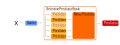

In [98]:
from IPython.display import SVG, display
display(SVG('images/tutorial_1.5.svg'))

*This pipeline is implemented with the code in the next cell.*  

This example illustrates the use of pipecaster's **SelectivePredictorStack** class and its performance advantage over scikit-learn's VotingClassifier.  SelectivePredictorStack is a single-channel ensemble classifier stack with the functionality of scikit-learn's VotingClassifier, VotingPredictor, StackingClassifier, and StackingRegressor classes.  In addition, SelectivePredictorStack allows you to select the best performing base models during fitting of the ensemble.  Base classifiers are usually trained via internal cross-validation in predictor stacks like these, and pipecaster takes advantage of the cross validation results to estimate the performance of each model in the ensemble.  In the example here, the top 2 models are selected and their inferences averaged via soft voting to generate an ensemble prediction.  Dropping inaccurate models from an ensemble can increase performance.

**SelectivePredictorStack** uses **SoftVotingClassifier** in this example to combine the inferences of the base classifiers.  Pipecaster also provides **HardVotingClassifier** and **AggregatingRegressor** classes for use in this context, and any appropriate scikit-learn predictor may be substituted (e.g. SVC or SVR).

In [131]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import pipecaster as pc

X, y_single = make_classification(n_classes=2, n_samples=500, n_features=100, 
                           n_informative=5, class_sep=0.6)

sk_voter = VotingClassifier(estimators=[('NN', MLPClassifier()), 
                                        ('LR', LogisticRegression()), 
                                        ('GBC', GradientBoostingClassifier()),
                                        ('RFC', RandomForestClassifier()),
                                        ('NB', GaussianNB())], 
                                        voting='soft')

sk_clf = Pipeline([('scaler', StandardScaler()), 
                ('voting classifier', sk_voter)])

mclf5 = pc.MultichannelPipeline(n_channels=1)
mclf5.add_layer(StandardScaler())
mclf5.add_layer(pc.SelectivePredictorStack(
                 base_predictors=[MLPClassifier(), 
                                  LogisticRegression(), 
                                  KNeighborsClassifier(),
                                  GradientBoostingClassifier(),
                                  RandomForestClassifier(),
                                  GaussianNB()], 
                 meta_predictor=pc.SoftVotingClassifier(),
                 internal_cv=5, scorer='auto',
                 score_selector=None, base_processes='max'))

mclf6 = pc.MultichannelPipeline(n_channels=1)
mclf6.add_layer(StandardScaler())
mclf6.add_layer(pc.SelectivePredictorStack(
                 base_predictors=[MLPClassifier(), 
                                  LogisticRegression(), 
                                  KNeighborsClassifier(),
                                  GradientBoostingClassifier(),
                                  RandomForestClassifier(),
                                  GaussianNB()], 
                 meta_predictor=pc.SoftVotingClassifier(),
                 internal_cv=5, scorer='auto',
                 score_selector=pc.RankScoreSelector(k=2), base_processes='max'))

,layer_0,out_0,layer_1,out_1
channel,,,,
0,StandardScaler,→,SelectivePredictorStack,→


In [ ]:
sk_accuracies = cross_val_score(sk_clf, X, y_single, scoring='balanced_accuracy', cv=5)
non_sel_accuracies = pc.cross_val_score(mclf5, [X], y_single, scorer=balanced_accuracy_score, cv=5)
sel_accuracies = pc.cross_val_score(mclf6, [X], y_single, scorer=balanced_accuracy_score, cv=5)

Text(0, 0.5, 'balanced accuracy')

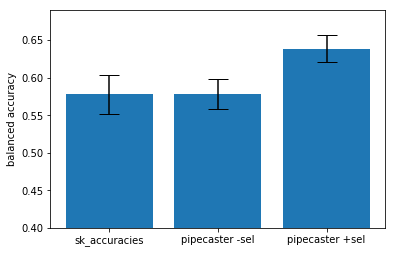

In [133]:
plt.bar(['sk_accuracies', 'pipecaster -sel', 'pipecaster +sel'],
        [np.mean(sk_accuracies), np.mean(non_sel_accuracies), np.mean(sel_accuracies)], 
        yerr= [sem(sk_accuracies), sem(non_sel_accuracies), sem(sel_accuracies)], capsize=10)
plt.ylim(.4)
plt.ylabel('balanced accuracy')

In [120]:
print('Models selected by the SelectivePredictorStack:')
mclf6.fit([X], y_single)
stack = mclf6.get_model_from_channel(layer_index=1, channel_index=0)
[pc.get_descriptor(bp) for i, bp in enumerate(stack.base_predictors) if i in stack.get_support()]

Models selected by the SelectivePredictorStack:


['{KNeighborsClassifier}cvtr', '{GradientBoostingClassifier}cvtr']

The cell above illustrates two useful functions: 
* **get_model_from_channel()** retrieves a fit model from the pipeline based on layer and channel indices.
* **stack.get_support()** get the indices of the base predictors that were selected during fitting.